# 1. import needed package

In [1]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn
from mxnet.gluon.data import vision
import numpy as np
import random
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from netlib import *
import os
import shutil

ctx = mx.gpu(0)

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

# 2. data loader, data argument

In [2]:
"""
data loader
"""
def _transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1))
    return im, nd.array([label]).astype('float32')


def data_loader(batch_size, transform_train, transform_test=None, num_workers=0):
    if transform_train is None:
        transform_train = _transform_train
    if transform_test is None:
        transform_test = _transform_test
        
    # flag=1 mean 3 channel image
    train_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=True, transform=transform_train)
    test_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=False, transform=transform_test)

    loader = gluon.data.DataLoader
    train_data = loader(train_ds, batch_size, shuffle=True, last_batch='keep', num_workers=num_workers)
    test_data = loader(test_ds, batch_size, shuffle=False, last_batch='keep', num_workers=num_workers)
    return train_data, test_data

In [3]:
"""
data argument
"""
def transform_train_DA1(data, label):
    im = data.asnumpy()
    im = np.pad(im, ((4, 4), (4, 4), (0, 0)), mode='constant', constant_values=0)
    im = nd.array(im, dtype='float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, rand_mirror=True,
                                    rand_crop=True,
                                   mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) # channel x width x height
    return im, nd.array([label]).astype('float32')


def transform_train_DA2(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
                                mean=np.array([0.4914, 0.4822, 0.4465]),
                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))
    
    for aug in auglist:
        im = aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))
    

random_clip_rate = 0.3
def transform_train_DA3(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
#                                mean=np.array([0.4914, 0.4822, 0.4465]),
#                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))

    for aug in auglist:
        im = aug(im)
        
    if random.random() > random_clip_rate:
        im = im.clip(0, 1)
    _aug = image.ColorNormalizeAug(mean=np.array([0.4914, 0.4822, 0.4465]),
                   std=np.array([0.2023, 0.1994, 0.2010]),)
    im = _aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))

# 3 data aurgument: mixup
1. mixup define
2. mixup visualize

## 3.1 mixup: define

In [4]:
import numpy as np
def mixup(x1, y1, x2, y2, alpha, num_class):
    y1 = nd.one_hot(y1, num_class)
    y2 = nd.one_hot(y2, num_class)
    
    lam = np.random.beta(alpha, alpha)
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y

## 3.2 mixup: visulize

In [5]:
from mxnet import gluon
from mxnet.gluon.model_zoo import vision as model
from time import time
batch_size = 32
transform_train = _transform_test#transform_train_DA1
train_data, test_data = data_loader(batch_size, transform_train)
mixup_alpha = 1

# for x1, y1 in train_data:
#     for x2, y2 in mixup_train_data:
#         data, label = mixup(x1, y1, x2, y2, mixup_alpha, 10)
#         break
#     break

for x, y in train_data:
    l = x.shape[0] / 2
    data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)
    break

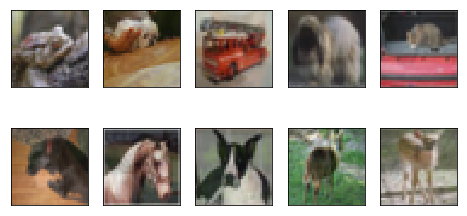

[(0, 'airplane'), (1, 'automobile'), (2, 'bird'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'frog'), (7, 'horse'), (8, 'ship'), (9, 'truck')]

[[[ 0.21255219  0.          0.          0.          0.          0.
    0.78744781  0.          0.          0.        ]]

 [[ 0.          0.          0.          0.          0.          0.78744781
    0.21255219  0.          0.          0.        ]]

 [[ 0.          0.          0.          0.21255219  0.          0.          0.
    0.          0.          0.78744781]]

 [[ 0.          0.          0.          0.          0.          0.78744781
    0.          0.          0.21255219  0.        ]]

 [[ 0.          0.          0.          0.78744781  0.21255219  0.          0.
    0.          0.          0.        ]]

 [[ 0.          0.          0.          0.          0.          1.          0.
    0.          0.          0.        ]]

 [[ 0.          0.          0.          0.          0.21255219  0.          0.
    0.78744781  0.          0.       

In [6]:
from cifar10_utils import show_images
%matplotlib inline
mean=np.array([0.4914, 0.4822, 0.4465])
std=np.array([0.2023, 0.1994, 0.2010])
images = data[:10].transpose((0, 2, 3, 1)).asnumpy()
images = images * std + mean
images = images.transpose((0, 3, 1, 2)) * 255
show_images(images)
#show_images(data[:9], rgb_mean=mean*255, std=std*255)

print [(i, l) for i, l in enumerate(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])]
print label[:10]

## 3.3 mixup: train

In [7]:
from time import time
mixup_test = False

if mixup_test:
    net = ResNet164_v2(10)
    net.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
    loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

    num_epochs = 1
    learning_rate = 0.1
    weight_decay = 1e-4

    cur_time = time()
    iters = 0
    """
    data loader first time run will cost about 3x time than after run.
    """
    for x1, y1 in train_data:
        if iters % 100 == 0:
            print iters, time() - cur_time
        iters += 1
    print "cost time:", time() - cur_time
    print
    cur_time = time()

    iters = 0
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})
    for x, y in train_data:
        l = x.shape[0] / 2
        data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)

        with autograd.record():
            output = net(data.as_in_context(ctx))
            loss = loss_f(output, label.as_in_context(ctx))
        loss.backward()
        trainer.step(data.shape[0])

        if iters % 100 == 0:
            print iters, time() - cur_time, nd.mean(loss).asscalar()
        iters += 1
    print iters, time() - cur_time

    # load data one by one batch
    # iters = 0
    # for x1, y1 in train_data:
    #     for x2, y2 in mixup_train_data:
    #         data, label = mixup(x1, y1, x2[:x1.shape[0]], y2[:y1.shape[0]], mixup_alpha, 10)
    #         break
    #     if iters % 100 == 0:
    #         print iters, time() - cur_time
    #     iters += 1
    # print "cost time:", time() - cur_time
    # print
    # cur_time = time()

    # zip will load all datas and then iterate them, too cost memory, will drop speed when memory over.
    # iters = 0
    # for (x1, y1), (x2, y2) in zip(train_data, mixup_train_data):
    #     data, label = mixup(x1, y1, x2, y2, mixup_alpha, 10)
    #     if iters % 100 == 0:
    #         print iters, time() - cur_time#, nd.mean(loss).asscalar()
    #     iters += 1
    # print time() - cur_time

# 4. define train function

In [8]:
"""
train
"""
import datetime
import utils
import sys

def abs_mean(W):
    return nd.mean(nd.abs(W)).asscalar()

def in_list(e, l):
    for i in l:
        if i == e:
            return True
    else:
        return False

def train(net, train_data, valid_data, num_epochs, lr, lr_period, 
          lr_decay, wd, ctx, w_key, output_file=None, verbose=False, loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), 
          use_mixup=False, mixup_alpha=0.2):
    def train_batch(data, label, i):
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data.as_in_context(ctx))
            loss = loss_f(output, label)
        loss.backward()
        trainer.step(data.shape[0])

        _loss = nd.mean(loss).asscalar()
        if not use_mixup:
            _acc = utils.accuracy(output, label)
        else:
            _acc = None

        if verbose and i % 100 == 0:
            print " # iter", i,
            print "loss %.5f" % _loss, 
            if not use_mixup: print "acc %.5f" % _acc,
            print "w (",
            for k in w_key:
                w = net.collect_params()[k]
                print "%.5f, " % abs_mean(w.data()),
            print ") g (",
            for k in w_key:
                w = net.collect_params()[k]
                print "%.5f, " % abs_mean(w.grad()),
            print ")"
        return _loss, _acc
            
    if output_file is None:
        output_file = sys.stdout
        stdout = sys.stdout
    else:
        output_file = open(output_file, "w")
        stdout = sys.stdout
        sys.stdout = output_file
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    prev_time = datetime.datetime.now()
    
    if verbose:
        print " #", utils.evaluate_accuracy(valid_data, net, ctx)
    
    i = 0
    for epoch in range(num_epochs):
        train_loss = 0.
        train_acc = 0.
        if in_list(epoch, lr_period):
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
            
        if not use_mixup:
            for data, label in train_data:
                _loss, _acc = train_batch(data, label, i)
                train_loss += _loss
                train_acc += _acc
                i += 1
        else:
            for x, y in train_data:
                l = x.shape[0] / 2
                data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)
                _loss, _ = train_batch(data, label, i)
                train_loss += _loss
                i += 1
        
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        
        train_loss /= len(train_data)
        train_acc /= len(train_data)
        
        if valid_data is not None:
            valid_acc = utils.evaluate_accuracy(valid_data, net, ctx)
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f, valid_acc %.4f" 
                         % (epoch, train_loss, train_acc, valid_acc))
        else:
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f"
                        % (epoch, train_loss, train_acc))
        prev_time = cur_time
        output_file.write(epoch_str + ", " + time_str + ",lr " + str(trainer.learning_rate) + "\n")
        output_file.flush()  # to disk only when flush or close
    if output_file != stdout:
        sys.stdout = stdout
        output_file.close()

# 5. get net and do EXP

1. how to use imagenet rihgt?
2. how to use strong DA? after weak DA or directly use.
3. how to train resnet completely.

4. DA1/DA2/mixup choose and finetune order

## 5.1.0 resnet18_v2

In [12]:
# create and add must in name_scope, or may got name error
def get_resnet18_v2():
    net = nn.HybridSequential()
    with net.name_scope():
        resnet = model.resnet18_v2(pretrained=True, ctx=ctx)
        output = nn.Dense(10)
        net.add(resnet.features)
        net.add(output)

    net.hybridize()
    output.initialize(ctx=ctx)
    return net

batch_size = 128
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

num_epochs = 120      # 50 * 1563 iter about
learning_rate = 0.1
weight_decay = 1e-4
lr_decay=0.1
log_file = None
w_key = []

## 5.1.1 simple test

In [11]:
lr_period = [60, 90, 110]
train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
net = get_resnet18_v2()

train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)
net.save_params("../../models/train3_resnet18_v2_finetune")

epoch 0, loss 3.19612, train_acc 0.1812, valid_acc 0.2742, Time 00:00:10,lr 0.1
epoch 1, loss 1.87783, train_acc 0.3034, valid_acc 0.3279, Time 00:00:13,lr 0.1
epoch 2, loss 1.72390, train_acc 0.3515, valid_acc 0.3970, Time 00:00:13,lr 0.1
epoch 3, loss 1.58213, train_acc 0.4137, valid_acc 0.4217, Time 00:00:14,lr 0.1
epoch 4, loss 1.45663, train_acc 0.4659, valid_acc 0.4310, Time 00:00:13,lr 0.1
epoch 5, loss 1.37210, train_acc 0.5031, valid_acc 0.5078, Time 00:00:14,lr 0.1
epoch 6, loss 1.30744, train_acc 0.5246, valid_acc 0.5442, Time 00:00:14,lr 0.1
epoch 7, loss 1.24122, train_acc 0.5529, valid_acc 0.5745, Time 00:00:13,lr 0.1
epoch 8, loss 1.17987, train_acc 0.5778, valid_acc 0.5951, Time 00:00:14,lr 0.1
epoch 9, loss 1.13067, train_acc 0.5949, valid_acc 0.6313, Time 00:00:13,lr 0.1
epoch 10, loss 1.08910, train_acc 0.6098, valid_acc 0.6373, Time 00:00:13,lr 0.1
epoch 11, loss 1.01933, train_acc 0.6365, valid_acc 0.6475, Time 00:00:14,lr 0.1
epoch 12, loss 0.98811, train_acc 0.64

epoch 101, loss 0.17236, train_acc 0.9395, valid_acc 0.8473, Time 00:00:13,lr 0.001
epoch 102, loss 0.17157, train_acc 0.9404, valid_acc 0.8481, Time 00:00:14,lr 0.001
epoch 103, loss 0.17134, train_acc 0.9404, valid_acc 0.8475, Time 00:00:14,lr 0.001
epoch 104, loss 0.16581, train_acc 0.9406, valid_acc 0.8474, Time 00:00:14,lr 0.001
epoch 105, loss 0.16578, train_acc 0.9414, valid_acc 0.8470, Time 00:00:15,lr 0.001
epoch 106, loss 0.16718, train_acc 0.9410, valid_acc 0.8475, Time 00:00:14,lr 0.001
epoch 107, loss 0.16727, train_acc 0.9410, valid_acc 0.8489, Time 00:00:14,lr 0.001
epoch 108, loss 0.16414, train_acc 0.9421, valid_acc 0.8488, Time 00:00:14,lr 0.001
epoch 109, loss 0.16236, train_acc 0.9431, valid_acc 0.8474, Time 00:00:14,lr 0.001
epoch 110, loss 0.16289, train_acc 0.9426, valid_acc 0.8462, Time 00:00:14,lr 0.0001
epoch 111, loss 0.16164, train_acc 0.9426, valid_acc 0.8479, Time 00:00:14,lr 0.0001
epoch 112, loss 0.16173, train_acc 0.9435, valid_acc 0.8475, Time 00:00:14

## 5.1.2 DA1 lr_peroid=[150, 250, 350]
I thought 5.1.1 is not good cuase not trian completely

In [10]:
net = get_resnet18_v2()
train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)

num_epochs = 150      # 50 * 1563 iter about
learning_rate = 0.1
lr_period = [150]

train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)
net.save_params("../../models/train3_resnet18_v2_finetune_DA1_e150")

epoch 0, loss 2.76288, train_acc 0.1891, valid_acc 0.2425, Time 00:00:10,lr 0.1
epoch 1, loss 1.82606, train_acc 0.3212, valid_acc 0.3795, Time 00:00:11,lr 0.1
epoch 2, loss 1.65041, train_acc 0.3860, valid_acc 0.4290, Time 00:00:11,lr 0.1
epoch 3, loss 1.51908, train_acc 0.4404, valid_acc 0.4803, Time 00:00:11,lr 0.1
epoch 4, loss 1.46011, train_acc 0.4700, valid_acc 0.5156, Time 00:00:11,lr 0.1
epoch 5, loss 1.40076, train_acc 0.4915, valid_acc 0.5219, Time 00:00:11,lr 0.1
epoch 6, loss 1.46110, train_acc 0.4724, valid_acc 0.4839, Time 00:00:11,lr 0.1
epoch 7, loss 1.41476, train_acc 0.4857, valid_acc 0.5232, Time 00:00:11,lr 0.1
epoch 8, loss 1.56326, train_acc 0.4328, valid_acc 0.4693, Time 00:00:11,lr 0.1
epoch 9, loss 1.41685, train_acc 0.4872, valid_acc 0.5236, Time 00:00:11,lr 0.1
epoch 10, loss 1.31954, train_acc 0.5228, valid_acc 0.5639, Time 00:00:11,lr 0.1
epoch 11, loss 1.23618, train_acc 0.5568, valid_acc 0.5688, Time 00:00:11,lr 0.1
epoch 12, loss 1.18017, train_acc 0.57

epoch 102, loss 0.43860, train_acc 0.8476, valid_acc 0.8165, Time 00:00:11,lr 0.1
epoch 103, loss 0.43661, train_acc 0.8479, valid_acc 0.7952, Time 00:00:11,lr 0.1
epoch 104, loss 0.43444, train_acc 0.8457, valid_acc 0.7984, Time 00:00:11,lr 0.1
epoch 105, loss 0.43892, train_acc 0.8464, valid_acc 0.8182, Time 00:00:11,lr 0.1
epoch 106, loss 0.42864, train_acc 0.8483, valid_acc 0.8088, Time 00:00:11,lr 0.1
epoch 107, loss 0.42585, train_acc 0.8514, valid_acc 0.7831, Time 00:00:11,lr 0.1
epoch 108, loss 0.43077, train_acc 0.8504, valid_acc 0.8051, Time 00:00:11,lr 0.1
epoch 109, loss 0.42805, train_acc 0.8493, valid_acc 0.8106, Time 00:00:11,lr 0.1
epoch 110, loss 0.42019, train_acc 0.8511, valid_acc 0.8154, Time 00:00:11,lr 0.1
epoch 111, loss 0.42386, train_acc 0.8498, valid_acc 0.8085, Time 00:00:11,lr 0.1
epoch 112, loss 0.42199, train_acc 0.8514, valid_acc 0.8059, Time 00:00:11,lr 0.1
epoch 113, loss 0.41956, train_acc 0.8521, valid_acc 0.8120, Time 00:00:11,lr 0.1
epoch 114, loss 

In [11]:
num_epochs = 100      # 100 + 150 epoch
learning_rate = 0.01
lr_period = [100]

net.load_params("../../models/train3_resnet18_v2_finetune_DA1_e150", ctx=ctx)
train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)
net.save_params("../../models/train3_resnet18_v2_finetune_DA1_e250")

epoch 0, loss 0.27494, train_acc 0.9036, valid_acc 0.8531, Time 00:00:09,lr 0.01
epoch 1, loss 0.23308, train_acc 0.9173, valid_acc 0.8568, Time 00:00:11,lr 0.01
epoch 2, loss 0.21313, train_acc 0.9240, valid_acc 0.8548, Time 00:00:11,lr 0.01
epoch 3, loss 0.20037, train_acc 0.9292, valid_acc 0.8565, Time 00:00:11,lr 0.01
epoch 4, loss 0.19582, train_acc 0.9303, valid_acc 0.8583, Time 00:00:11,lr 0.01
epoch 5, loss 0.18779, train_acc 0.9335, valid_acc 0.8574, Time 00:00:11,lr 0.01
epoch 6, loss 0.18050, train_acc 0.9360, valid_acc 0.8593, Time 00:00:11,lr 0.01
epoch 7, loss 0.17190, train_acc 0.9377, valid_acc 0.8585, Time 00:00:11,lr 0.01
epoch 8, loss 0.16845, train_acc 0.9406, valid_acc 0.8590, Time 00:00:11,lr 0.01
epoch 9, loss 0.16648, train_acc 0.9400, valid_acc 0.8552, Time 00:00:11,lr 0.01
epoch 10, loss 0.16247, train_acc 0.9421, valid_acc 0.8586, Time 00:00:11,lr 0.01
epoch 11, loss 0.15294, train_acc 0.9463, valid_acc 0.8601, Time 00:00:11,lr 0.01
epoch 12, loss 0.15478, tr

In [12]:
num_epochs = 100      # 100 + 150 epoch
learning_rate = 0.001
lr_period = [100]

net.load_params("../../models/train3_resnet18_v2_finetune_DA1_e250", ctx=ctx)
train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)
net.save_params("../../models/train3_resnet18_v2_finetune_DA1_e350")

epoch 0, loss 0.05284, train_acc 0.9826, valid_acc 0.8580, Time 00:00:10,lr 0.001
epoch 1, loss 0.04562, train_acc 0.9853, valid_acc 0.8588, Time 00:00:11,lr 0.001
epoch 2, loss 0.04212, train_acc 0.9863, valid_acc 0.8604, Time 00:00:11,lr 0.001
epoch 3, loss 0.04051, train_acc 0.9867, valid_acc 0.8598, Time 00:00:11,lr 0.001
epoch 4, loss 0.03794, train_acc 0.9878, valid_acc 0.8611, Time 00:00:11,lr 0.001
epoch 5, loss 0.03741, train_acc 0.9884, valid_acc 0.8600, Time 00:00:11,lr 0.001
epoch 6, loss 0.03595, train_acc 0.9886, valid_acc 0.8595, Time 00:00:11,lr 0.001
epoch 7, loss 0.03529, train_acc 0.9894, valid_acc 0.8614, Time 00:00:11,lr 0.001
epoch 8, loss 0.03540, train_acc 0.9892, valid_acc 0.8615, Time 00:00:11,lr 0.001
epoch 9, loss 0.03170, train_acc 0.9902, valid_acc 0.8606, Time 00:00:11,lr 0.001
epoch 10, loss 0.03246, train_acc 0.9902, valid_acc 0.8608, Time 00:00:11,lr 0.001
epoch 11, loss 0.03148, train_acc 0.9902, valid_acc 0.8621, Time 00:00:11,lr 0.001
epoch 12, loss

epoch 99, loss 0.01719, train_acc 0.9948, valid_acc 0.8623, Time 00:00:11,lr 0.001


## 5.1.3 finetune begin with small lr
I thought use big lr will not show the benifit of finetune

In [13]:
net = get_resnet18_v2()
train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)

num_epochs = 80      # 50 * 1563 iter about
learning_rate = 0.001
lr_period = [80]

train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)
net.save_params("../../models/train3_resnet18_v2_finetune_small_lr_e80")

epoch 0, loss 1.28070, train_acc 0.5484, valid_acc 0.6659, Time 00:00:09,lr 0.001
epoch 1, loss 0.87181, train_acc 0.6942, valid_acc 0.7318, Time 00:00:11,lr 0.001
epoch 2, loss 0.75666, train_acc 0.7330, valid_acc 0.7585, Time 00:00:11,lr 0.001
epoch 3, loss 0.67932, train_acc 0.7616, valid_acc 0.7797, Time 00:00:11,lr 0.001
epoch 4, loss 0.62995, train_acc 0.7807, valid_acc 0.7881, Time 00:00:11,lr 0.001
epoch 5, loss 0.59185, train_acc 0.7945, valid_acc 0.7990, Time 00:00:11,lr 0.001
epoch 6, loss 0.55680, train_acc 0.8047, valid_acc 0.8007, Time 00:00:11,lr 0.001
epoch 7, loss 0.53603, train_acc 0.8130, valid_acc 0.8134, Time 00:00:11,lr 0.001
epoch 8, loss 0.50757, train_acc 0.8222, valid_acc 0.8152, Time 00:00:11,lr 0.001
epoch 9, loss 0.48074, train_acc 0.8317, valid_acc 0.8184, Time 00:00:11,lr 0.001
epoch 10, loss 0.45911, train_acc 0.8391, valid_acc 0.8214, Time 00:00:11,lr 0.001
epoch 11, loss 0.44425, train_acc 0.8454, valid_acc 0.8180, Time 00:00:11,lr 0.001
epoch 12, loss

In [14]:
num_epochs = 40      # 50 * 1563 iter about
learning_rate = 0.0001
lr_period = [40]
net.load_params("../../models/train3_resnet18_v2_finetune_small_lr_e80", ctx=ctx)
train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)
net.save_params("../../models/train3_resnet18_v2_finetune_small_lr_e120")

epoch 0, loss 0.04797, train_acc 0.9834, valid_acc 0.8493, Time 00:00:09,lr 0.0001
epoch 1, loss 0.04121, train_acc 0.9862, valid_acc 0.8484, Time 00:00:11,lr 0.0001
epoch 2, loss 0.03944, train_acc 0.9867, valid_acc 0.8523, Time 00:00:11,lr 0.0001
epoch 3, loss 0.03901, train_acc 0.9874, valid_acc 0.8501, Time 00:00:11,lr 0.0001
epoch 4, loss 0.03566, train_acc 0.9884, valid_acc 0.8516, Time 00:00:11,lr 0.0001
epoch 5, loss 0.03694, train_acc 0.9884, valid_acc 0.8539, Time 00:00:11,lr 0.0001
epoch 6, loss 0.03435, train_acc 0.9887, valid_acc 0.8518, Time 00:00:11,lr 0.0001
epoch 7, loss 0.03511, train_acc 0.9885, valid_acc 0.8508, Time 00:00:11,lr 0.0001
epoch 8, loss 0.03544, train_acc 0.9886, valid_acc 0.8509, Time 00:00:11,lr 0.0001
epoch 9, loss 0.03100, train_acc 0.9902, valid_acc 0.8514, Time 00:00:11,lr 0.0001
epoch 10, loss 0.03248, train_acc 0.9900, valid_acc 0.8529, Time 00:00:11,lr 0.0001
epoch 11, loss 0.03225, train_acc 0.9901, valid_acc 0.8531, Time 00:00:11,lr 0.0001
ep

## 5.1.4 try DA2

In [15]:
train_data, valid_data = data_loader(batch_size, transform_train_DA2, num_workers=3)
net = get_resnet18_v2()

num_epochs = 150      # 50 * 1563 iter about
learning_rate = 0.1
lr_period = [150]

train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)
net.save_params("../../models/train3_resnet18_v2_finetune_DA2_e150")

epoch 0, loss 3.11658, train_acc 0.1416, valid_acc 0.2111, Time 00:00:20,lr 0.1
epoch 1, loss 2.09582, train_acc 0.2126, valid_acc 0.3123, Time 00:00:21,lr 0.1
epoch 2, loss 1.95817, train_acc 0.2712, valid_acc 0.3694, Time 00:00:21,lr 0.1
epoch 3, loss 1.84647, train_acc 0.3231, valid_acc 0.4040, Time 00:00:21,lr 0.1
epoch 4, loss 1.76677, train_acc 0.3577, valid_acc 0.4454, Time 00:00:21,lr 0.1
epoch 5, loss 1.70275, train_acc 0.3834, valid_acc 0.4674, Time 00:00:21,lr 0.1
epoch 6, loss 1.64178, train_acc 0.4087, valid_acc 0.4802, Time 00:00:21,lr 0.1
epoch 7, loss 1.60851, train_acc 0.4211, valid_acc 0.5013, Time 00:00:21,lr 0.1
epoch 8, loss 1.53296, train_acc 0.4511, valid_acc 0.5281, Time 00:00:21,lr 0.1
epoch 9, loss 1.47802, train_acc 0.4725, valid_acc 0.5324, Time 00:00:21,lr 0.1
epoch 10, loss 1.43122, train_acc 0.4918, valid_acc 0.5658, Time 00:00:21,lr 0.1
epoch 11, loss 1.53871, train_acc 0.4492, valid_acc 0.2993, Time 00:00:21,lr 0.1
epoch 12, loss 1.84977, train_acc 0.32

epoch 102, loss 0.67687, train_acc 0.7662, valid_acc 0.7782, Time 00:00:21,lr 0.1
epoch 103, loss 0.67751, train_acc 0.7670, valid_acc 0.7813, Time 00:00:21,lr 0.1
epoch 104, loss 0.67318, train_acc 0.7685, valid_acc 0.7808, Time 00:00:21,lr 0.1
epoch 105, loss 0.66943, train_acc 0.7691, valid_acc 0.7823, Time 00:00:21,lr 0.1
epoch 106, loss 0.67118, train_acc 0.7677, valid_acc 0.7928, Time 00:00:21,lr 0.1
epoch 107, loss 0.66830, train_acc 0.7686, valid_acc 0.7750, Time 00:00:21,lr 0.1
epoch 108, loss 0.66392, train_acc 0.7721, valid_acc 0.8018, Time 00:00:21,lr 0.1
epoch 109, loss 0.65623, train_acc 0.7736, valid_acc 0.7922, Time 00:00:21,lr 0.1
epoch 110, loss 0.65318, train_acc 0.7747, valid_acc 0.7908, Time 00:00:21,lr 0.1
epoch 111, loss 0.65489, train_acc 0.7735, valid_acc 0.7892, Time 00:00:21,lr 0.1
epoch 112, loss 0.65816, train_acc 0.7740, valid_acc 0.7902, Time 00:00:21,lr 0.1
epoch 113, loss 0.65512, train_acc 0.7769, valid_acc 0.7834, Time 00:00:21,lr 0.1
epoch 114, loss 

In [16]:
num_epochs = 100      # 100 + 150 epoch
learning_rate = 0.01
lr_period = [100]

net.load_params("../../models/train3_resnet18_v2_finetune_DA2_e150", ctx=ctx)
train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)
net.save_params("../../models/train3_resnet18_v2_finetune_DA2_e250")

epoch 0, loss 0.51322, train_acc 0.8236, valid_acc 0.8331, Time 00:00:20,lr 0.01
epoch 1, loss 0.46838, train_acc 0.8386, valid_acc 0.8359, Time 00:00:21,lr 0.01
epoch 2, loss 0.44826, train_acc 0.8455, valid_acc 0.8392, Time 00:00:21,lr 0.01
epoch 3, loss 0.43397, train_acc 0.8479, valid_acc 0.8416, Time 00:00:21,lr 0.01
epoch 4, loss 0.42680, train_acc 0.8532, valid_acc 0.8440, Time 00:00:21,lr 0.01
epoch 5, loss 0.42267, train_acc 0.8544, valid_acc 0.8429, Time 00:00:21,lr 0.01
epoch 6, loss 0.41589, train_acc 0.8567, valid_acc 0.8442, Time 00:00:21,lr 0.01
epoch 7, loss 0.40887, train_acc 0.8574, valid_acc 0.8473, Time 00:00:21,lr 0.01
epoch 8, loss 0.40575, train_acc 0.8579, valid_acc 0.8425, Time 00:00:21,lr 0.01
epoch 9, loss 0.39781, train_acc 0.8612, valid_acc 0.8458, Time 00:00:21,lr 0.01
epoch 10, loss 0.39084, train_acc 0.8652, valid_acc 0.8451, Time 00:00:21,lr 0.01
epoch 11, loss 0.38765, train_acc 0.8656, valid_acc 0.8448, Time 00:00:21,lr 0.01
epoch 12, loss 0.38949, tr

In [17]:
num_epochs = 100      # 100 + 150 epoch
learning_rate = 0.001
lr_period = [100]

net.load_params("../../models/train3_resnet18_v2_finetune_DA2_e150", ctx=ctx)
train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)
net.save_params("../../models/train3_resnet18_v2_finetune_DA2_e250")

epoch 0, loss 0.57669, train_acc 0.8041, valid_acc 0.8167, Time 00:00:20,lr 0.001
epoch 1, loss 0.53490, train_acc 0.8162, valid_acc 0.8238, Time 00:00:21,lr 0.001
epoch 2, loss 0.51747, train_acc 0.8224, valid_acc 0.8280, Time 00:00:21,lr 0.001
epoch 3, loss 0.50795, train_acc 0.8260, valid_acc 0.8278, Time 00:00:21,lr 0.001
epoch 4, loss 0.49265, train_acc 0.8292, valid_acc 0.8269, Time 00:00:21,lr 0.001
epoch 5, loss 0.48383, train_acc 0.8342, valid_acc 0.8315, Time 00:00:21,lr 0.001
epoch 6, loss 0.47790, train_acc 0.8353, valid_acc 0.8309, Time 00:00:21,lr 0.001
epoch 7, loss 0.47156, train_acc 0.8379, valid_acc 0.8309, Time 00:00:21,lr 0.001
epoch 8, loss 0.47058, train_acc 0.8381, valid_acc 0.8314, Time 00:00:21,lr 0.001
epoch 9, loss 0.46141, train_acc 0.8386, valid_acc 0.8338, Time 00:00:21,lr 0.001
epoch 10, loss 0.46309, train_acc 0.8405, valid_acc 0.8344, Time 00:00:21,lr 0.001
epoch 11, loss 0.45508, train_acc 0.8403, valid_acc 0.8358, Time 00:00:21,lr 0.001
epoch 12, loss

epoch 99, loss 0.36646, train_acc 0.8726, valid_acc 0.8503, Time 00:00:21,lr 0.001


## 5.1.5 try DA2 use net train with DA1

In [18]:
train_data, valid_data = data_loader(batch_size, transform_train_DA2, num_workers=3)
net = get_resnet18_v2()

num_epochs = 100      # 50 * 1563 iter about
learning_rate = 0.001
lr_period = [150]

net.load_params("../../models/train3_resnet18_v2_finetune_DA1_e250", ctx=ctx)
train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)
net.save_params("../../models/train3_resnet18_v2_finetune_DA2_afterDA1e250_e100")

epoch 0, loss 0.99687, train_acc 0.7539, valid_acc 0.8322, Time 00:00:20,lr 0.001
epoch 1, loss 0.75326, train_acc 0.7850, valid_acc 0.8325, Time 00:00:21,lr 0.001
epoch 2, loss 0.68016, train_acc 0.7939, valid_acc 0.8352, Time 00:00:21,lr 0.001
epoch 3, loss 0.62057, train_acc 0.8034, valid_acc 0.8363, Time 00:00:22,lr 0.001
epoch 4, loss 0.59461, train_acc 0.8088, valid_acc 0.8396, Time 00:00:21,lr 0.001
epoch 5, loss 0.55887, train_acc 0.8153, valid_acc 0.8420, Time 00:00:21,lr 0.001
epoch 6, loss 0.54601, train_acc 0.8200, valid_acc 0.8440, Time 00:00:21,lr 0.001
epoch 7, loss 0.52265, train_acc 0.8250, valid_acc 0.8448, Time 00:00:21,lr 0.001
epoch 8, loss 0.52356, train_acc 0.8250, valid_acc 0.8432, Time 00:00:21,lr 0.001
epoch 9, loss 0.50462, train_acc 0.8294, valid_acc 0.8438, Time 00:00:21,lr 0.001
epoch 10, loss 0.50508, train_acc 0.8290, valid_acc 0.8449, Time 00:00:21,lr 0.001
epoch 11, loss 0.49400, train_acc 0.8350, valid_acc 0.8457, Time 00:00:21,lr 0.001
epoch 12, loss

epoch 99, loss 0.34729, train_acc 0.8795, valid_acc 0.8534, Time 00:00:21,lr 0.001


## 5.1.5 try DA2 use imagenet finetune

In [19]:
train_data, valid_data = data_loader(batch_size, transform_train_DA2, num_workers=3)
net = get_resnet18_v2()

num_epochs = 120      # 50 * 1563 iter about
learning_rate = 0.001
lr_period = [80]

train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)
net.save_params("../../models/train3_resnet18_v2_finetune_DA2_small_lr_e120")

epoch 0, loss 1.37907, train_acc 0.5171, valid_acc 0.6732, Time 00:00:20,lr 0.001
epoch 1, loss 0.98552, train_acc 0.6540, valid_acc 0.7287, Time 00:00:21,lr 0.001
epoch 2, loss 0.88241, train_acc 0.6923, valid_acc 0.7486, Time 00:00:21,lr 0.001
epoch 3, loss 0.82404, train_acc 0.7127, valid_acc 0.7690, Time 00:00:21,lr 0.001
epoch 4, loss 0.76971, train_acc 0.7321, valid_acc 0.7729, Time 00:00:21,lr 0.001
epoch 5, loss 0.74007, train_acc 0.7424, valid_acc 0.7854, Time 00:00:21,lr 0.001
epoch 6, loss 0.70770, train_acc 0.7541, valid_acc 0.7922, Time 00:00:21,lr 0.001
epoch 7, loss 0.68088, train_acc 0.7619, valid_acc 0.7990, Time 00:00:21,lr 0.001
epoch 8, loss 0.66286, train_acc 0.7699, valid_acc 0.8018, Time 00:00:21,lr 0.001
epoch 9, loss 0.64915, train_acc 0.7741, valid_acc 0.8026, Time 00:00:21,lr 0.001
epoch 10, loss 0.62471, train_acc 0.7834, valid_acc 0.8100, Time 00:00:21,lr 0.001
epoch 11, loss 0.61559, train_acc 0.7847, valid_acc 0.8126, Time 00:00:21,lr 0.001
epoch 12, loss

epoch 99, loss 0.23610, train_acc 0.9179, valid_acc 0.8596, Time 00:00:21,lr 0.0001
epoch 100, loss 0.23601, train_acc 0.9181, valid_acc 0.8603, Time 00:00:21,lr 0.0001
epoch 101, loss 0.23521, train_acc 0.9176, valid_acc 0.8606, Time 00:00:21,lr 0.0001
epoch 102, loss 0.23208, train_acc 0.9182, valid_acc 0.8599, Time 00:00:21,lr 0.0001
epoch 103, loss 0.23638, train_acc 0.9196, valid_acc 0.8619, Time 00:00:21,lr 0.0001
epoch 104, loss 0.23010, train_acc 0.9197, valid_acc 0.8614, Time 00:00:21,lr 0.0001
epoch 105, loss 0.22912, train_acc 0.9209, valid_acc 0.8612, Time 00:00:21,lr 0.0001
epoch 106, loss 0.22961, train_acc 0.9217, valid_acc 0.8596, Time 00:00:21,lr 0.0001
epoch 107, loss 0.22829, train_acc 0.9202, valid_acc 0.8620, Time 00:00:21,lr 0.0001
epoch 108, loss 0.23068, train_acc 0.9199, valid_acc 0.8628, Time 00:00:21,lr 0.0001
epoch 109, loss 0.22720, train_acc 0.9208, valid_acc 0.8641, Time 00:00:22,lr 0.0001
epoch 110, loss 0.23003, train_acc 0.9202, valid_acc 0.8620, Time 

## 5.1.6 try mixup

In [20]:
batch_size = 128
train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=3)
loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

net = get_resnet18_v2()

num_epochs = 350      # 50 * 1563 iter about
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [150, 250]
lr_decay=0.1
log_file = None

w_key = []
train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f, use_mixup=True, mixup_alpha=0.2)
net.save_params("../../models/train3_resnet18_v2_finetune_mixup")

epoch 0, loss 3.20680, train_acc 0.0000, valid_acc 0.2596, Time 00:00:11,lr 0.1
epoch 1, loss 1.96925, train_acc 0.0000, valid_acc 0.3252, Time 00:00:12,lr 0.1
epoch 2, loss 1.84118, train_acc 0.0000, valid_acc 0.3862, Time 00:00:12,lr 0.1
epoch 3, loss 1.76241, train_acc 0.0000, valid_acc 0.3886, Time 00:00:12,lr 0.1
epoch 4, loss 1.72654, train_acc 0.0000, valid_acc 0.4518, Time 00:00:12,lr 0.1
epoch 5, loss 1.69166, train_acc 0.0000, valid_acc 0.4454, Time 00:00:12,lr 0.1
epoch 6, loss 1.68581, train_acc 0.0000, valid_acc 0.4613, Time 00:00:12,lr 0.1
epoch 7, loss 1.63838, train_acc 0.0000, valid_acc 0.5050, Time 00:00:12,lr 0.1
epoch 8, loss 1.55155, train_acc 0.0000, valid_acc 0.5331, Time 00:00:12,lr 0.1
epoch 9, loss 1.57070, train_acc 0.0000, valid_acc 0.5259, Time 00:00:12,lr 0.1
epoch 10, loss 1.55299, train_acc 0.0000, valid_acc 0.5209, Time 00:00:12,lr 0.1
epoch 11, loss 1.63187, train_acc 0.0000, valid_acc 0.4830, Time 00:00:12,lr 0.1
epoch 12, loss 1.53881, train_acc 0.00

epoch 102, loss 0.95967, train_acc 0.0000, valid_acc 0.7734, Time 00:00:12,lr 0.1
epoch 103, loss 0.92482, train_acc 0.0000, valid_acc 0.7807, Time 00:00:12,lr 0.1
epoch 104, loss 0.99490, train_acc 0.0000, valid_acc 0.7628, Time 00:00:12,lr 0.1
epoch 105, loss 0.97915, train_acc 0.0000, valid_acc 0.7627, Time 00:00:12,lr 0.1
epoch 106, loss 0.96403, train_acc 0.0000, valid_acc 0.7781, Time 00:00:12,lr 0.1
epoch 107, loss 0.94653, train_acc 0.0000, valid_acc 0.7798, Time 00:00:12,lr 0.1
epoch 108, loss 0.92119, train_acc 0.0000, valid_acc 0.7889, Time 00:00:12,lr 0.1
epoch 109, loss 0.93430, train_acc 0.0000, valid_acc 0.7683, Time 00:00:12,lr 0.1
epoch 110, loss 0.94448, train_acc 0.0000, valid_acc 0.7991, Time 00:00:12,lr 0.1
epoch 111, loss 0.94373, train_acc 0.0000, valid_acc 0.7870, Time 00:00:12,lr 0.1
epoch 112, loss 0.96400, train_acc 0.0000, valid_acc 0.7738, Time 00:00:12,lr 0.1
epoch 113, loss 0.92215, train_acc 0.0000, valid_acc 0.7690, Time 00:00:12,lr 0.1
epoch 114, loss 

epoch 202, loss 0.68213, train_acc 0.0000, valid_acc 0.8616, Time 00:00:12,lr 0.01
epoch 203, loss 0.66956, train_acc 0.0000, valid_acc 0.8566, Time 00:00:12,lr 0.01
epoch 204, loss 0.68738, train_acc 0.0000, valid_acc 0.8548, Time 00:00:12,lr 0.01
epoch 205, loss 0.64160, train_acc 0.0000, valid_acc 0.8508, Time 00:00:12,lr 0.01
epoch 206, loss 0.67941, train_acc 0.0000, valid_acc 0.8530, Time 00:00:12,lr 0.01
epoch 207, loss 0.64575, train_acc 0.0000, valid_acc 0.8585, Time 00:00:12,lr 0.01
epoch 208, loss 0.66259, train_acc 0.0000, valid_acc 0.8629, Time 00:00:12,lr 0.01
epoch 209, loss 0.66337, train_acc 0.0000, valid_acc 0.8558, Time 00:00:12,lr 0.01
epoch 210, loss 0.65602, train_acc 0.0000, valid_acc 0.8577, Time 00:00:12,lr 0.01
epoch 211, loss 0.64681, train_acc 0.0000, valid_acc 0.8563, Time 00:00:12,lr 0.01
epoch 212, loss 0.66006, train_acc 0.0000, valid_acc 0.8543, Time 00:00:12,lr 0.01
epoch 213, loss 0.69104, train_acc 0.0000, valid_acc 0.8580, Time 00:00:12,lr 0.01
epoc

epoch 301, loss 0.55164, train_acc 0.0000, valid_acc 0.8673, Time 00:00:12,lr 0.001
epoch 302, loss 0.56074, train_acc 0.0000, valid_acc 0.8693, Time 00:00:12,lr 0.001
epoch 303, loss 0.59132, train_acc 0.0000, valid_acc 0.8688, Time 00:00:12,lr 0.001
epoch 304, loss 0.57373, train_acc 0.0000, valid_acc 0.8646, Time 00:00:12,lr 0.001
epoch 305, loss 0.59050, train_acc 0.0000, valid_acc 0.8676, Time 00:00:12,lr 0.001
epoch 306, loss 0.54857, train_acc 0.0000, valid_acc 0.8705, Time 00:00:12,lr 0.001
epoch 307, loss 0.52638, train_acc 0.0000, valid_acc 0.8730, Time 00:00:12,lr 0.001
epoch 308, loss 0.52827, train_acc 0.0000, valid_acc 0.8663, Time 00:00:12,lr 0.001
epoch 309, loss 0.55569, train_acc 0.0000, valid_acc 0.8687, Time 00:00:12,lr 0.001
epoch 310, loss 0.51560, train_acc 0.0000, valid_acc 0.8689, Time 00:00:12,lr 0.001
epoch 311, loss 0.53696, train_acc 0.0000, valid_acc 0.8661, Time 00:00:12,lr 0.001
epoch 312, loss 0.56155, train_acc 0.0000, valid_acc 0.8695, Time 00:00:12,l

## 5.1.7 mixup finetune DA1e250

In [21]:
batch_size = 128
train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=3)
loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

net = get_resnet18_v2()

num_epochs = 120      # 50 * 1563 iter about
learning_rate = 0.001
weight_decay = 1e-4
lr_period = [80]

net.load_params("../../models/train3_resnet18_v2_finetune_DA1_e250", ctx=ctx)

w_key = []
train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f, use_mixup=True, mixup_alpha=0.2)
net.save_params("../../models/train3_resnet18_v2_finetune_agterDA1e250_mixup")

epoch 0, loss 1.04917, train_acc 0.0000, valid_acc 0.8296, Time 00:00:10,lr 0.001
epoch 1, loss 0.83445, train_acc 0.0000, valid_acc 0.8164, Time 00:00:12,lr 0.001
epoch 2, loss 0.80262, train_acc 0.0000, valid_acc 0.8288, Time 00:00:12,lr 0.001
epoch 3, loss 0.75816, train_acc 0.0000, valid_acc 0.8304, Time 00:00:12,lr 0.001
epoch 4, loss 0.66389, train_acc 0.0000, valid_acc 0.8422, Time 00:00:12,lr 0.001
epoch 5, loss 0.68028, train_acc 0.0000, valid_acc 0.8384, Time 00:00:12,lr 0.001
epoch 6, loss 0.68301, train_acc 0.0000, valid_acc 0.8416, Time 00:00:12,lr 0.001
epoch 7, loss 0.66096, train_acc 0.0000, valid_acc 0.8482, Time 00:00:12,lr 0.001
epoch 8, loss 0.68089, train_acc 0.0000, valid_acc 0.8482, Time 00:00:12,lr 0.001
epoch 9, loss 0.60168, train_acc 0.0000, valid_acc 0.8499, Time 00:00:12,lr 0.001
epoch 10, loss 0.58366, train_acc 0.0000, valid_acc 0.8509, Time 00:00:12,lr 0.001
epoch 11, loss 0.63316, train_acc 0.0000, valid_acc 0.8511, Time 00:00:12,lr 0.001
epoch 12, loss

epoch 99, loss 0.54879, train_acc 0.0000, valid_acc 0.8683, Time 00:00:12,lr 0.0001
epoch 100, loss 0.57475, train_acc 0.0000, valid_acc 0.8681, Time 00:00:12,lr 0.0001
epoch 101, loss 0.55174, train_acc 0.0000, valid_acc 0.8699, Time 00:00:12,lr 0.0001
epoch 102, loss 0.55255, train_acc 0.0000, valid_acc 0.8683, Time 00:00:12,lr 0.0001
epoch 103, loss 0.54742, train_acc 0.0000, valid_acc 0.8690, Time 00:00:12,lr 0.0001
epoch 104, loss 0.61386, train_acc 0.0000, valid_acc 0.8638, Time 00:00:12,lr 0.0001
epoch 105, loss 0.57141, train_acc 0.0000, valid_acc 0.8691, Time 00:00:12,lr 0.0001
epoch 106, loss 0.53535, train_acc 0.0000, valid_acc 0.8705, Time 00:00:12,lr 0.0001
epoch 107, loss 0.52410, train_acc 0.0000, valid_acc 0.8711, Time 00:00:12,lr 0.0001
epoch 108, loss 0.51386, train_acc 0.0000, valid_acc 0.8666, Time 00:00:12,lr 0.0001
epoch 109, loss 0.56098, train_acc 0.0000, valid_acc 0.8675, Time 00:00:12,lr 0.0001
epoch 110, loss 0.55949, train_acc 0.0000, valid_acc 0.8704, Time 

## 5.2 resnet152_v2

In [9]:
# create and add must in name_scope, or may got name error
def get_resnet152_v2():
    net = nn.HybridSequential()
    with net.name_scope():
        resnet = model.resnet152_v2(pretrained=True, ctx=ctx)
        output = nn.Dense(10)
        net.add(resnet.features)
        net.add(output)

    net.hybridize()
    output.initialize(ctx=ctx)
    return net

In [ ]:
net = get_resnet152_v2()
train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=3)

num_epochs = 150      # 50 * 1563 iter about
learning_rate = 0.1
lr_period = [150]

train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)
net.save_params("../../models/train3_resnet152_v2_finetune_DA1_e150")

In [ ]:
num_epochs = 100      # 100 + 150 epoch
learning_rate = 0.01
lr_period = [100]

net.load_params("../../models/train3_resnet152_v2_finetune_DA1_e150", ctx=ctx)
train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)
net.save_params("../../models/train3_resnet152_v2_finetune_DA1_e250")

In [ ]:
num_epochs = 100      # 100 + 150 epoch
learning_rate = 0.001
lr_period = [100]

net.load_params("../../models/train3_resnet152_v2_finetune_DA1_e250", ctx=ctx)
train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)
net.save_params("../../models/train3_resnet152_v2_finetune_DA1_e350")